# Homework: Image Analysis

Your goal for this assignment is to beat my best error rate on the [Butterfly Image Classifier](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) at all costs. In addition to your code, submit a screenshot of your validation error rate, along with a text statement certifying that it is not a doctored image.

Here is mine: at the end of the last epoch, I achieved an error rate of 0.062. Based on the train/valid losses, I probably could have trained longer and gotten a lower error rate, but I did not. The lowest error rate I saw on people's Kaggle notebooks was about 0.10, anyway.

[You're welcome](https://www.youtube.com/watch?v=79DijItQXMM).


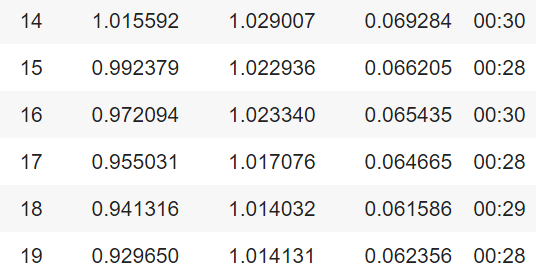


You *must*:
* Split the data into training and validation data randomly using a RandomSplitter with a seed of 314159 and a valid fraction of 0.2. This way you and I will be testing against the same data.

You *may*:
* Do **anything** else.

## Getting Started

* This dataset is not organized the same way as the other image datasets you've seen. You will have to write your own function to get the labels, instead of the `parent_label` function. Such a function must accept a single filename as a string (or maybe it's a path? Just cast it as a string, I guess) as an argument, and then return the proper label (also a string).
* The dataset is pretty large in terms of number of images. Resizing it for preliminary training, then going back to full size after a certain point is a good idea.

## Image Resizing

Here's the image resizing code I gave you in class, in case the CPU read is the bottleneck, rather than the GPU. I copied this from Jeremy Howard's [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series, in which he did some similar stuff (mainly the resizing) for a different competition. You may want to steal some of his code as well.

I'm not modifying this to help you. Figure it out.

In [ ]:
from fastai.vision.all import *
import pandas as pd

In [ ]:
%env KAGGLE_USERNAME="donnydutch"
%env KAGGLE_KEY="e000856dbf910d714ae70609d63d00aa"

!kaggle datasets download -d phucthaiv02/butterfly-image-classification
!unzip butterfly-image-classification



Streaming output truncated to the last 5000 lines.
  inflating: train/Image_2348.jpg    
  inflating: train/Image_2349.jpg    
  inflating: train/Image_235.jpg     
  inflating: train/Image_2350.jpg    
  inflating: train/Image_2351.jpg    
  inflating: train/Image_2352.jpg    
  inflating: train/Image_2353.jpg    
  inflating: train/Image_2354.jpg    
  inflating: train/Image_2355.jpg    
  inflating: train/Image_2356.jpg    
  inflating: train/Image_2357.jpg    
  inflating: train/Image_2358.jpg    
  inflating: train/Image_2359.jpg    
  inflating: train/Image_236.jpg     
  inflating: train/Image_2360.jpg    
  inflating: train/Image_2361.jpg    
  inflating: train/Image_2362.jpg    
  inflating: train/Image_2363.jpg    
  inflating: train/Image_2364.jpg    
  inflating: train/Image_2365.jpg    
  inflating: train/Image_2366.jpg    
  inflating: train/Image_2367.jpg    
  inflating: train/Image_2368.jpg    
  inflating: train/Image_2369.jpg    
  inflating: train/Image_237.jpg     

In [ ]:
Training_set = pd.read_csv("Training_set.csv")
Training_set = Training_set.rename(columns = {"label":"parent_label"})
Training_set.to_csv('Training_set.csv', index=False)

In [ ]:
Testing_set = pd.read_csv("Testing_set.csv")

In [ ]:
path = Path("/content")
path.ls()
#https://www.kaggle.com/code/derekxue/butterflyclassification-fastai

(#7) [Path('/content/.config'),Path('/content/test'),Path('/content/butterfly-image-classification.zip'),Path('/content/Testing_set.csv'),Path('/content/Training_set.csv'),Path('/content/train'),Path('/content/sample_data')]

In [ ]:
img_path = get_image_files(path/'train')
img_path[0]

Path('/content/train/Image_2402.jpg')

In [ ]:
# This take about 5 minutes to run, but will provide you with
# much smaller, uniform images when running things later.

# files = (path/"train").ls()
# small_path = Path("small_images")

# resize_images(path/'train', dest=small_path, max_size=256, recurse=True)
# resize_images(path/'test', dest=small_path, max_size=256, recurse=True)

#TRAMSFORMS
-----

In [ ]:
item_tfms = Resize(224, method='squish')

In [ ]:
batch_tfms = [*aug_transforms(
                    size=224, max_warp=0,
                    flip_vert=True, do_flip=True, max_rotate=45.0,
                    min_zoom=0.7, max_lighting=0.4),
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
butterfly = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_x = ColReader(['filename'], pref=f'{path}/train/'),
        get_y = ColReader(['parent_label']),
        splitter = RandomSplitter(valid_pct=0.2,seed=314159),
        item_tfms = Resize(224, method='squish'),
        batch_tfms = [*aug_transforms(
                    size=224, max_warp=0,
                    flip_vert=True, do_flip=True, max_rotate=45.0,
                    min_zoom=0.7, max_lighting=0.4),
              Normalize.from_stats(*imagenet_stats)]
        )

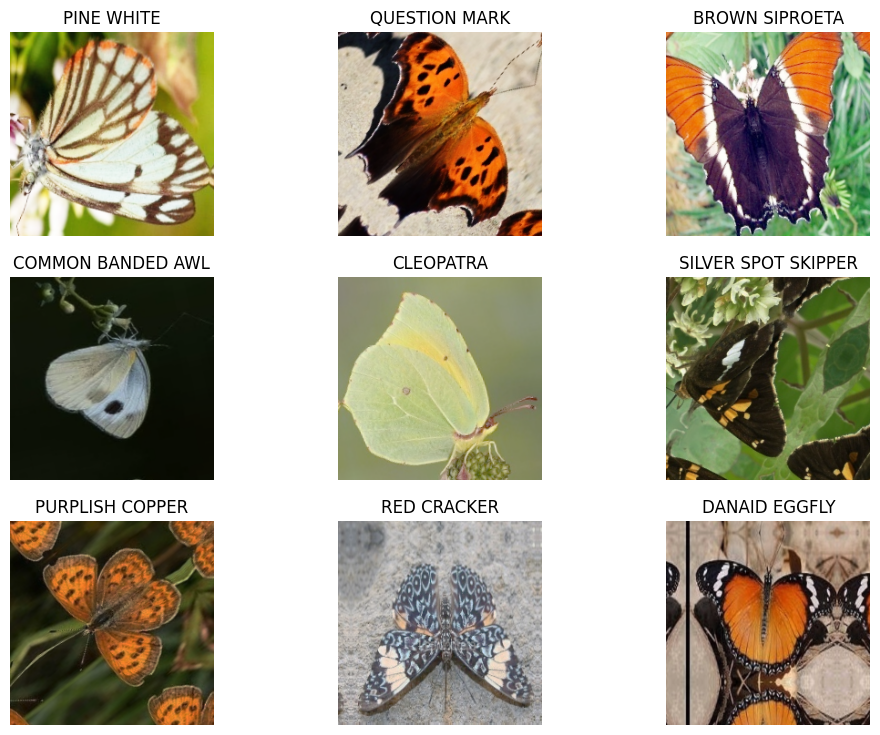

In [ ]:
dls = butterfly.dataloaders(Training_set, bs=16, shuffle=True)
dls.show_batch(max_n=6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.002511886414140463)

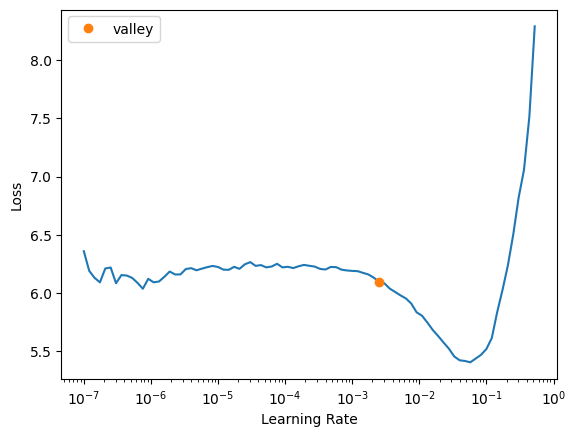

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.lr_find()

In [ ]:
learn.fine_tune(12, 0.0025) #0.060186

epoch,train_loss,valid_loss,error_rate,time
0,2.029192,0.936709,0.248653,00:26


epoch,train_loss,valid_loss,error_rate,time
0,1.059943,0.513056,0.142417,00:29
1,0.812370,0.415788,0.111624,00:29
2,0.807388,0.459750,0.125481,00:30
3,0.690950,0.471833,0.118553,00:30
4,0.523554,0.421795,0.107005,00:29
5,0.522262,0.378597,0.093149,00:29
6,0.372522,0.389985,0.096228,00:29
7,0.297759,0.338473,0.073903,00:29
8,0.214353,0.324471,0.073903,00:30
9,0.161648,0.300966,0.060816,00:30


In [ ]:
#I DIDDNT PHOTOSHOP I SWEAR!!!